In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import precision_recall_fscore_support as prfs
plt.ion()


In [6]:
os.listdir('./train')

['Almond Pudding',
 'Caramel Pudding',
 'Chocolate Milk Black Sugar Boba Tea',
 'Double Taro Signature',
 'Herbal Jelly 1',
 'Herbal Jelly 4',
 'Matcha Egg Waffle',
 'Mike Tea w Mini Taro Balls',
 'Mung Bean Cakes',
 'Original Ice Cream Egg Waffle',
 'Q Mochi Combo',
 'Small Taro Ball Tofu Pudding',
 'Taro Ball 6',
 'Taro Ball Signature',
 'Winter Melon Tea w small Taro Ball']

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation*?<>
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
data_dir = './'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),  data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def imshow(inp, title=None):
    """
    Imshow for Tensor
    parameter: transformed image matrix,title=None
    return: showing the image
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
# Get a batch of training data
#inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
#out = torchvision.utils.make_grid(inputs)

#imshow(out, title=[class_names[x] for x in classes])


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Model trainer
    parameter: pytorch model, criterion, optimizer, scheduler, num_epochs=25
    return: showing the image
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss_lst = []
    train_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == "train":
                train_loss_lst.append(epoch_loss)
                train_acc_lst.append(epoch_acc)
            elif phase == 'val':
                val_loss_lst.append(epoch_loss)
                val_acc_lst.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True,
                                    figsize=(12, 6))
    ax0.set_title('Loss')
    ax0.plot(range(len(train_loss_lst)), train_loss_lst, 'o-', label = 'train')
    ax0.plot(range(len(val_loss_lst)), val_loss_lst, 'o-', label = 'val')
    ax0.legend()
    ax0.set_xlabel('epoch #')

    ax1.set_title('Accuracy')
    ax1.plot(range(len(train_acc_lst)),  train_acc_lst, 'o-', label = 'train')
    ax1.plot(range(len(val_acc_lst)),  val_acc_lst, 'o-', label = 'val')
    ax1.legend()
    ax1.set_xlabel('epoch #')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    """
    Print the predicted results of images
    parameter: Pytorch model, num_images=6
    return: The predicted results of images
    """
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
def success_metrics(model):
    """
    Print evaluation of the model
    parameter: Pytorch model, (dataloaders['val'])
    return: precision, recall, f1, support
    """
    model.eval()
    original_labels = []
    pred_lst = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            original_labels.extend(labels)
            pred_lst.extend(preds)
            
    precision, recall, f1, support = prfs(original_labels, pred_lst, average='weighted')

    print("Precision: {:.2%}\nRecall: {:.2%}\nF1 score: {:.2%}".format(precision, recall, f1))

In [16]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 15)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

In [14]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/20
----------
train Loss: 2.8041 Acc: 0.0317
val Loss: 2.9737 Acc: 0.0351

Epoch 1/20
----------
train Loss: 2.8333 Acc: 0.0159
val Loss: 2.9762 Acc: 0.0351

Epoch 2/20
----------
train Loss: 2.8381 Acc: 0.0397
val Loss: 2.9801 Acc: 0.0351

Epoch 3/20
----------
train Loss: 2.7905 Acc: 0.0397
val Loss: 2.9857 Acc: 0.0351

Epoch 4/20
----------
train Loss: 2.7783 Acc: 0.0397
val Loss: 2.9854 Acc: 0.0351

Epoch 5/20
----------
train Loss: 2.8208 Acc: 0.0476
val Loss: 2.9823 Acc: 0.0351

Epoch 6/20
----------
train Loss: 2.8244 Acc: 0.0159
val Loss: 2.9838 Acc: 0.0351

Epoch 7/20
----------
train Loss: 2.8255 Acc: 0.0238
val Loss: 2.9887 Acc: 0.0351

Epoch 8/20
----------
train Loss: 2.8233 Acc: 0.0317
val Loss: 2.9873 Acc: 0.0351

Epoch 9/20
----------
train Loss: 2.7928 Acc: 0.0635
val Loss: 2.9859 Acc: 0.0351

Epoch 10/20
----------
train Loss: 2.8093 Acc: 0.0397
val Loss: 2.9876 Acc: 0.0351

Epoch 11/20
----------
train Loss: 2.8134 Acc: 0.0476
val Loss: 2.9869 Acc: 0.0351

Ep

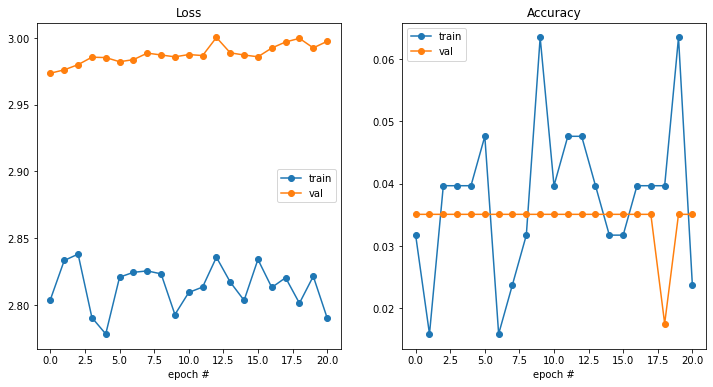

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,  num_epochs=21)

torch.save(model_ft, "./tlmodel")

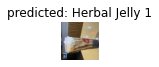

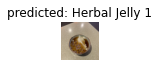

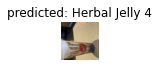

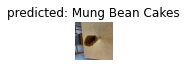

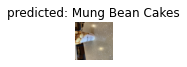

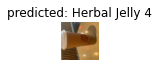

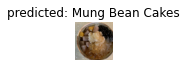

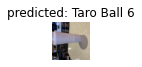

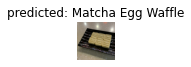

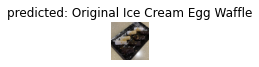

Precision: 1.10%
Recall: 3.51%
F1 score: 1.62%


In [19]:
visualize_model(model_ft, num_images=10)
success_metrics(model_ft)

In [11]:
def filedirinput(s=sys.argv):
    """
    File input reader
    parameter: sys.argv
    return: Image address
    """
    print ('Number of arguments:', len(sys.argv), 'arguments.')
    print ('Argument List:', str(sys.argv))
    if len(s) ==2:
        pred_dir = s[1]
    else:
        print("Wrong input. Choose to predict image in ./unknown")
        pred_dir = './unknown'
    return pred_dir

NameError: name 'sys' is not defined

In [21]:
def logoclassifier(model, loc = './unknown'):
    """
    logo classifier
    parameter: Model, Image address
    return: Image class
    """
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with open("class_names.txt", 'r') as f:
        class_names = [line.rstrip('\n') for line in f]
    unknown_img = datasets.ImageFolder(loc, data_transforms)
    loaded_img = torch.utils.data.DataLoader(unknown_img, batch_size = 1)
    model.eval()
    original_labels = []
    pred_lst = []
    
    for i, (inputs, labels) in enumerate(loaded_img):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        original_labels.extend(labels)
        pred_lst.extend(preds)
        imshow(inputs.cpu().data[0])
        print('Predicted: ', class_names[preds[0]])
    precision, recall, f1, support = prfs(original_labels, pred_lst, average='weighted')
    print("Precision: {:.2%}\nRecall: {:.2%}\nF1 score: {:.2%}".format(precision, recall, f1))
    return original_labels, pred_lst

In [14]:
# Image to be classified
pred_dir = filedirinput(s=sys.argv)

NameError: name 'filedirinput' is not defined

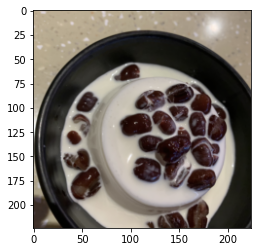

Predicted:  Mung Bean Cakes


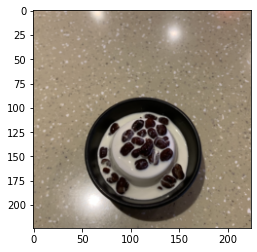

Predicted:  Mung Bean Cakes


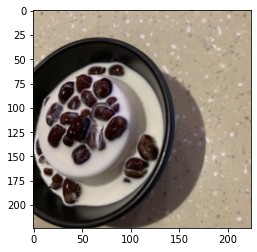

Predicted:  Mung Bean Cakes


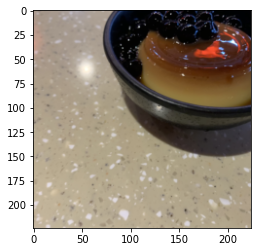

Predicted:  Winter Melon Tea w small Taro Ball


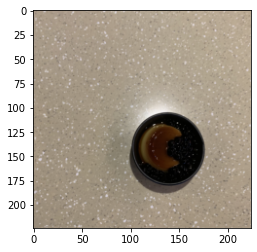

Predicted:  Taro Ball 6


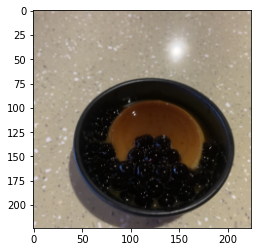

Predicted:  Mung Bean Cakes


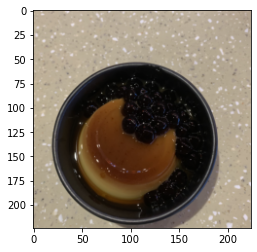

Predicted:  Mung Bean Cakes


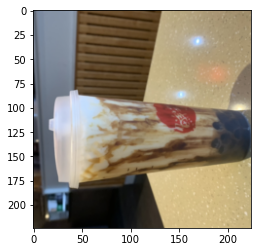

Predicted:  Herbal Jelly 1


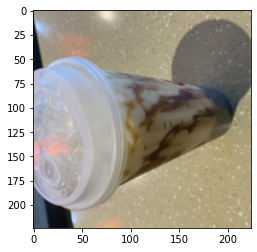

Predicted:  Mung Bean Cakes


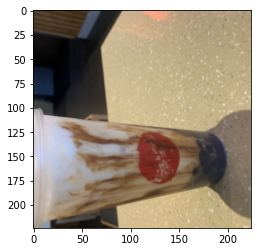

Predicted:  Herbal Jelly 4


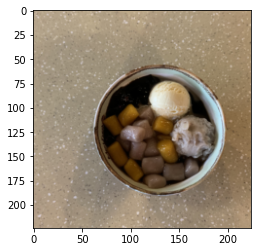

Predicted:  Mung Bean Cakes


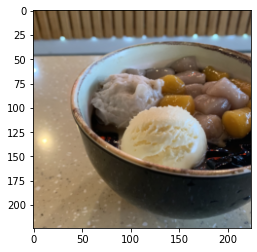

Predicted:  Herbal Jelly 1


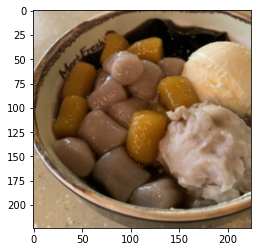

Predicted:  Herbal Jelly 1


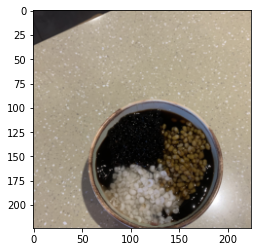

Predicted:  Mung Bean Cakes


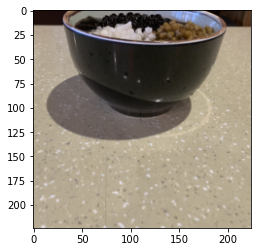

Predicted:  Matcha Egg Waffle


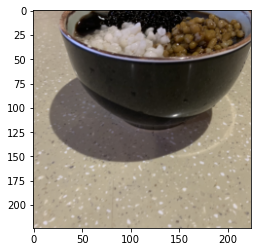

Predicted:  Matcha Egg Waffle


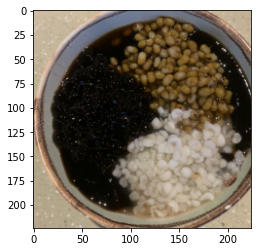

Predicted:  Mung Bean Cakes


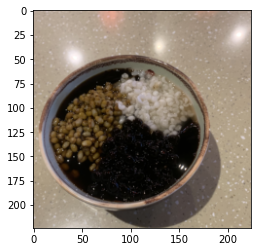

Predicted:  Herbal Jelly 1


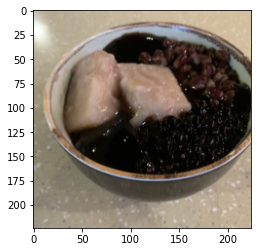

Predicted:  Matcha Egg Waffle


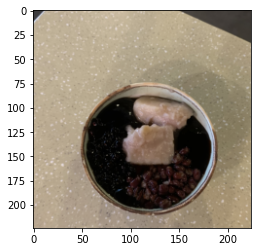

Predicted:  Mung Bean Cakes


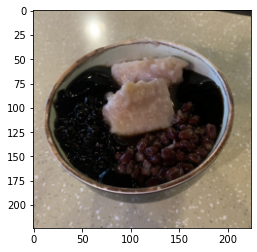

Predicted:  Herbal Jelly 1


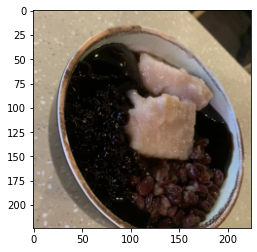

Predicted:  Taro Ball 6


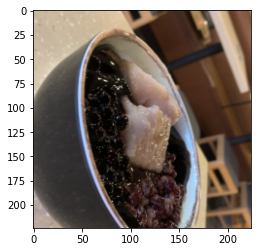

Predicted:  Taro Ball 6


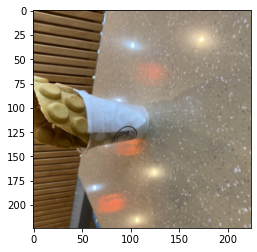

Predicted:  Herbal Jelly 1


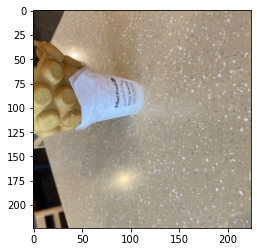

Predicted:  Mike Tea w Mini Taro Balls


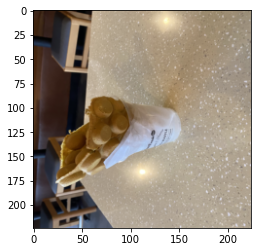

Predicted:  Mike Tea w Mini Taro Balls


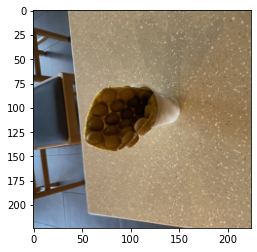

Predicted:  Mung Bean Cakes


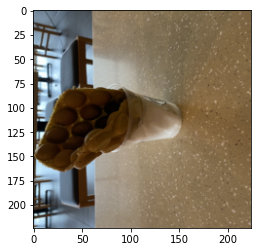

Predicted:  Herbal Jelly 4


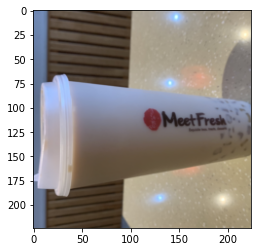

Predicted:  Herbal Jelly 1


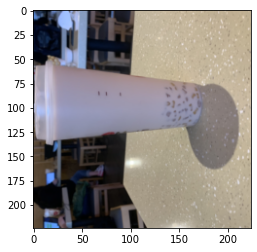

Predicted:  Taro Ball 6


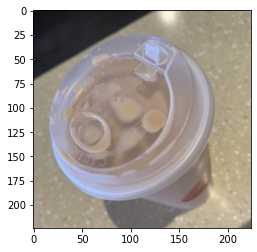

Predicted:  Taro Ball 6


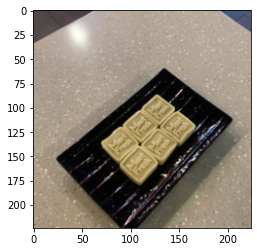

Predicted:  Mung Bean Cakes


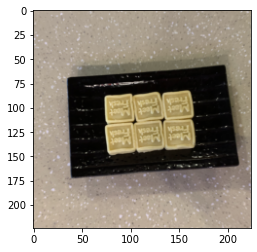

Predicted:  Winter Melon Tea w small Taro Ball


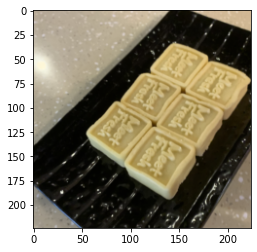

Predicted:  Taro Ball 6


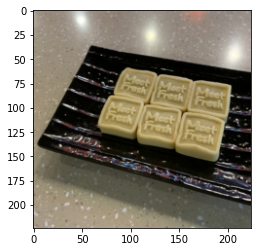

Predicted:  Matcha Egg Waffle


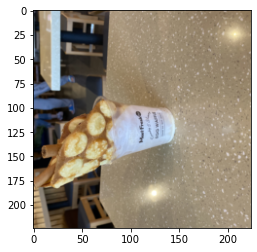

Predicted:  Mung Bean Cakes


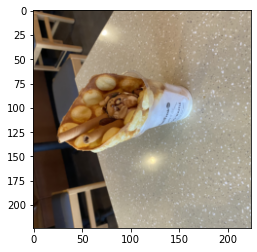

Predicted:  Mung Bean Cakes


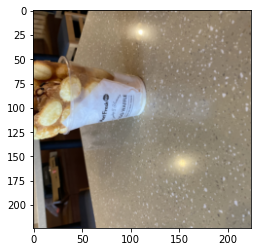

Predicted:  Mung Bean Cakes


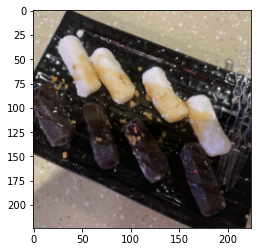

Predicted:  Mung Bean Cakes


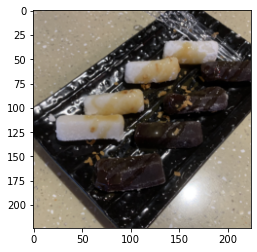

Predicted:  Original Ice Cream Egg Waffle


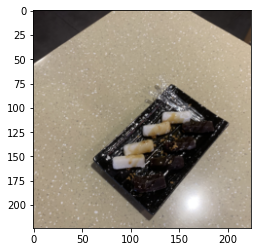

Predicted:  Mung Bean Cakes


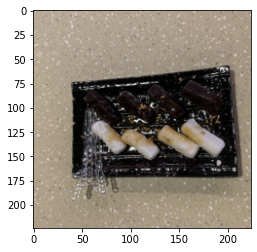

Predicted:  Mike Tea w Mini Taro Balls


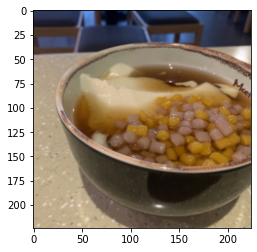

Predicted:  Winter Melon Tea w small Taro Ball


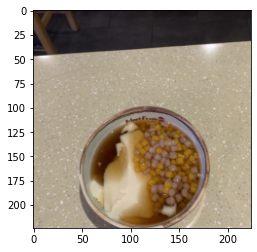

Predicted:  Mung Bean Cakes


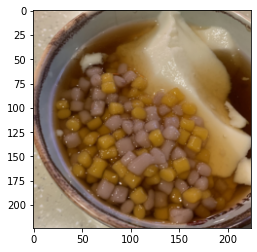

Predicted:  Mung Bean Cakes


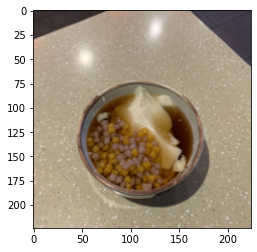

Predicted:  Herbal Jelly 1


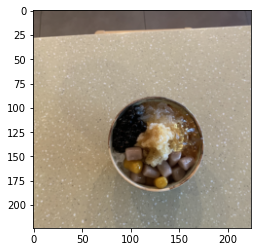

Predicted:  Mung Bean Cakes


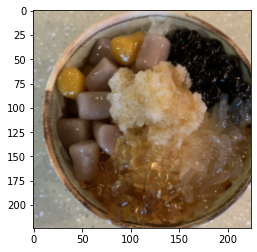

Predicted:  Mung Bean Cakes


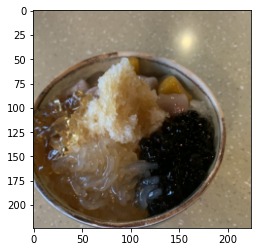

Predicted:  Original Ice Cream Egg Waffle


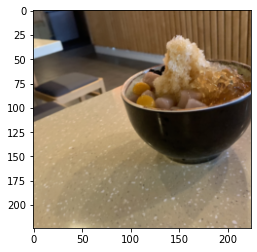

Predicted:  Mung Bean Cakes


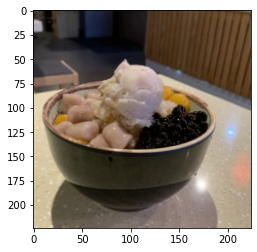

Predicted:  Herbal Jelly 1


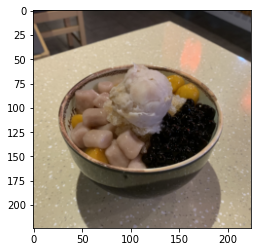

Predicted:  Herbal Jelly 1


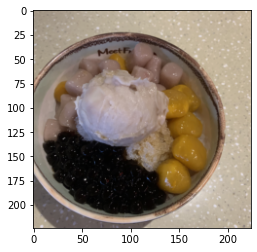

Predicted:  Winter Melon Tea w small Taro Ball


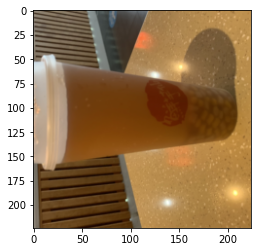

Predicted:  Herbal Jelly 4


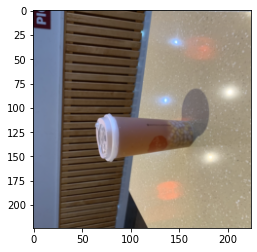

Predicted:  Herbal Jelly 1


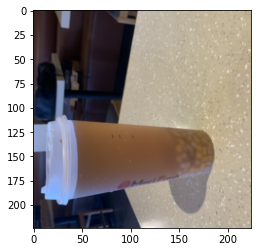

Predicted:  Herbal Jelly 4


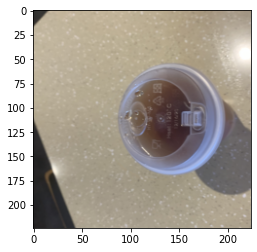

Predicted:  Mung Bean Cakes
Precision: 1.10%
Recall: 3.51%
F1 score: 1.62%


In [23]:
# Model input
model = torch.load("./tlmodel")
model.eval()
corr_lst, pred_lst = logoclassifier(model, loc = './val')

In [7]:
snacks = ['Almond Pudding',
 'Caramel Pudding',
 'Chocolate Milk Black Sugar Boba Tea',
 'Double Taro Signature',
 'Herbal Jelly 1',
 'Herbal Jelly 4',
 'Matcha Egg Waffle',
 'Mike Tea w Mini Taro Balls',
 'Mung Bean Cakes',
 'Original Ice Cream Egg Waffle',
 'Q Mochi Combo',
 'Small Taro Ball Tofu Pudding',
 'Taro Ball 6',
 'Taro Ball Signature',
 'Winter Melon Tea w small Taro Ball']
x = range(len(snacks))

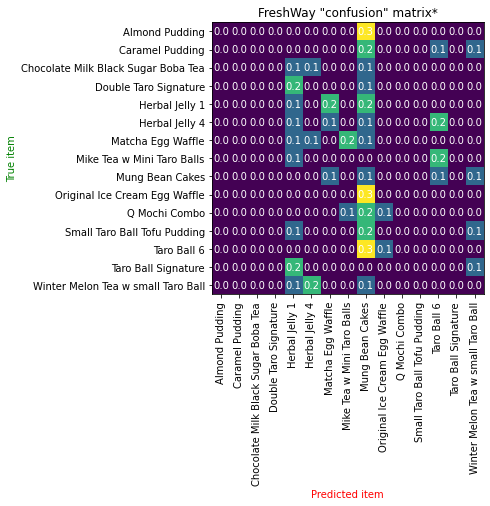

In [27]:
# confision matrix
bD = np.zeros((15, 15))
for i in range(len(pred_lst)):
    bD[corr_lst[i], pred_lst[i]] += 1

plt.figure(figsize=(5,5))
plt.imshow(bD/10)
plt.xticks(x, snacks, rotation=90)
plt.yticks(x, snacks)
plt.title('FreshWay "confusion" matrix*')
plt.xlabel('Predicted item', color='Red')
plt.ylabel('True item', color='Green')
for i in range(len(snacks)):
    for j in range(len(snacks)):
        text = plt.text(j, i, bD[i, j]/10,ha="center", va="center", color="w")
plt.show()

In [29]:
precision_, recall_, f1_, support_ = prfs(corr_lst, pred_lst, average=None)

In [46]:
precision_

array([0.625     , 1.        , 0.66666667, 1.        , 0.77777778])

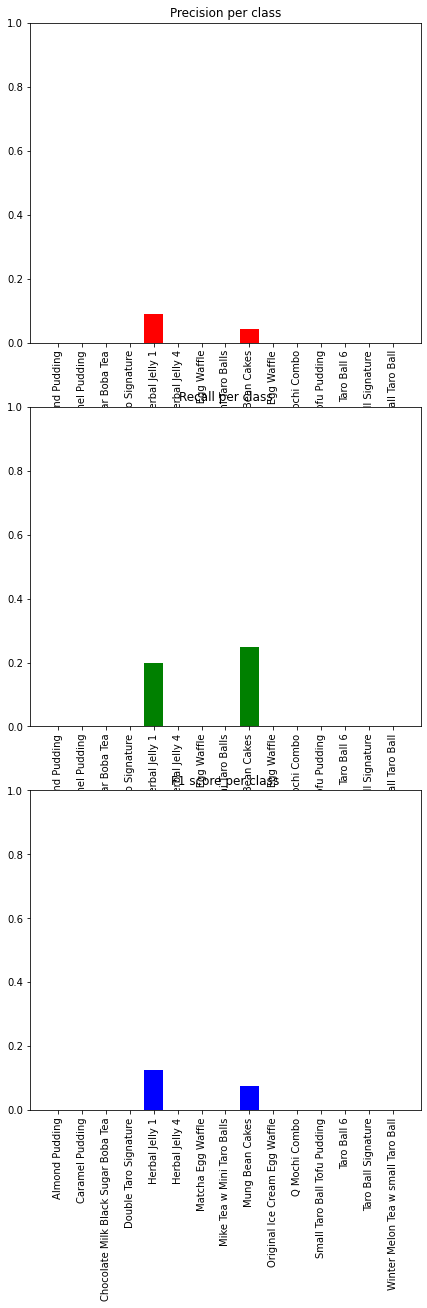

In [30]:
# per class recall and precision
plt.subplots(figsize=(7,20))
x = range(len(snacks))
plt.subplot(311)
plt.title('Precision per class')
plt.ylim(0, 1.00)
plt.bar(x, precision_, color='Red')
plt.xticks(x, snacks, rotation = 90)
plt.subplot(312)
plt.title('Recall per class')
plt.ylim(0, 1.00)
plt.bar(x, recall_, color='Green')
plt.xticks(x, snacks, rotation = 90)
plt.subplot(313)
plt.title('F1 score per class')
plt.ylim(0, 1.00)
plt.bar(x, f1_, color='Blue')
plt.xticks(x, snacks, rotation = 90)
plt.show()